In [2]:
import json
import time
import requests
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon, MultiPolygon, shape
from tqdm import tqdm_notebook

In [3]:
grid = gpd.read_file('/Users/juliatuvaleva/Documents/marchi/grid_nn_adm_2km.geojson')

In [182]:
u1 = 'https://geonn.grad-nn.ru/proxy.php?url=http%3A%2F%2Flocalhost%3A8080%2Fgeoserver%2FORCL_PORTAL%2Fows%3Fservice%3DWFS%26version%3D1.0.0%26request%3DGetFeature%26outputFormat%3Dapplication%252Fjson%26typeName%3DORCL_PORTAL%3AV_PORTAL2_EXIST_BUILDINGS_G%26CQL_FILTER%3DBBOX(GEOMETRY%2C4891202.585768893%2C7625609.351990765%2C4894501.868473824%2C7626775.779063208)'
#u1 = 'https://geonn.grad-nn.ru/proxy.php?url=http%3A%2F%2Flocalhost%3A8080%2Fgeoserver%2FORCL_PORTAL%2Fows%3Fservice%3DWFS%26version%3D1.0.0%26request%3DGetFeature%26outputFormat%3Dapplication%252Fjson%26typeName%3DORCL_PORTAL%3AGEO_ADDRESS%26CQL_FILTER%3DBBOX(GEOMETRY%2C4891202.585768893%2C7625609.351990765%2C4894501.868473824%2C7626775.779063208)'

response = requests.get(u1)

In [190]:
request_url = 'https://geonn.grad-nn.ru/proxy.php?url=http%3A%2F%2Flocalhost%3A8080%2Fgeoserver%2FORCL_PORTAL%2Fows%3Fservice%3DWFS%26version%3D1.0.0%26request%3DGetFeature%26outputFormat%3Dapplication%252Fjson%26typeName%3DORCL_PORTAL%3AV_PORTAL2_EXIST_BUILDINGS_G%26CQL_FILTER'

In [256]:
all_geom = gpd.GeoDataFrame()

In [257]:
fail_id = []

In [258]:
for i in tqdm_notebook(grid.index):
    try:
        lonmin = grid.loc[i, 'left']
        latmin = grid.loc[i, 'bottom']
        lonmax = grid.loc[i, 'right']
        latmax = grid.loc[i, 'top']

        bbox = '%3DBBOX(GEOMETRY%2C{}%2C{}%2C{}%2C{})'.format(lonmin, latmin, lonmax, latmax)
        response_geo = requests.get(request_url+bbox)

        df = response_geo.json()
        target_bbox_geom = pd.DataFrame(df['features'])
        target_bbox_geom['geometry'] = target_bbox_geom['geometry'].apply(lambda x: shape(x))
        target_bbox_geom['bldg_id'] = target_bbox_geom['id'].apply(lambda x: x.split('G.')[1])
        target_bbox_geom = target_bbox_geom[['bldg_id', 'geometry']]
        all_geom  = all_geom.append(target_bbox_geom)
    except:
        fail_id.append(i)

In [259]:
all_geom = all_geom.drop_duplicates(subset = 'bldg_id')
if len(all_geom.bldg_id.unique()) == len(all_geom):
    all_geom.to_csv('/Users/juliatuvaleva/Documents/marchi/geonn/nn_bldg_geom.csv', index = False)
else:
    print('Check data')

In [260]:
len(all_geom)

57410

In [4]:
part4 = pd.read_csv('/Users/juliatuvaleva/Documents/marchi/geonn/part4_geom.csv')
all_geom = part4

In [5]:
all_geom = all_geom.reset_index(drop = True)

In [6]:
all_geom.head()

,bldg_id,geometry
0,100351821,POLYGON Z ((4883424.11956191 7629935.31429569 ...
1,100393479,POLYGON Z ((4883268.90512601 7629947.60106258 ...
2,100352234,POLYGON Z ((4883469.96690046 7629965.00200922 ...
3,100375824,POLYGON Z ((4883371.30793866 7629966.00013855 ...
4,100350143,POLYGON Z ((4883354.13286506 7629982.61547146 ...


In [7]:
all_bldg_attr = pd.DataFrame()

In [8]:
fail_attr = []

In [9]:
for i in tqdm_notebook(all_geom.index):
    try:
        bldg_id = all_geom.loc[i, 'bldg_id']
        bldg_url = 'https://geonn.grad-nn.ru/proxy.php?url=http%3A%2F%2Flocalhost%3A8080%2Fgeoserver%2FORCL_PORTAL%2Fows%3Fservice%3DWFS%26version%3D1.0.0%26request%3DGetFeature%26outputFormat%3Dapplication%252Fjson%26typeName%3DORCL_PORTAL%3AV_PORTAL2_EXIST_BUILDINGS_A%26featureID%3DV_PORTAL2_EXIST_BUILDINGS_A.{}'.format(bldg_id)

        response_attr = requests.get(bldg_url)
        df_attr = response_attr.json()
        df_tmp = pd.DataFrame(df_attr['features'])
        all_bldg_attr = all_bldg_attr.append(df_tmp)
    except:
        fail_attr.append(i)
        

In [10]:
all_bldg_attr = all_bldg_attr.reset_index(drop = True)

all_bldg_attr['BUILD_NAME'] = all_bldg_attr['properties'].apply(lambda x: x['BUILD_NAME'])
all_bldg_attr['FLOORS'] = all_bldg_attr['properties'].apply(lambda x: x['FLOORS'])
all_bldg_attr['FUNCTIONALITY_NAME'] = all_bldg_attr['properties'].apply(lambda x: x['FUNCTIONALITY_NAME'])
all_bldg_attr['BUILDINGS_CONDITION_NAME'] = all_bldg_attr['properties'].apply(lambda x: x['BUILDINGS_CONDITION_NAME'])
all_bldg_attr['ADDRESS'] = all_bldg_attr['properties'].apply(lambda x: x['ADDRESS'])
all_bldg_attr['BUILD_YEAR'] = all_bldg_attr['properties'].apply(lambda x: x['BUILD_YEAR'])
all_bldg_attr['BUILDING_STATE'] = all_bldg_attr['properties'].apply(lambda x: x['BUILDING_STATE'])


In [11]:
all_bldg_text_description = all_bldg_attr[['id', 'BUILDING_STATE']]

In [12]:
all_bldg_attr = all_bldg_attr.drop(labels = ['type','geometry', 'properties', 'BUILDING_STATE'], axis = 1)

In [13]:
len(all_bldg_attr)

2846

In [14]:
all_bldg_attr.head()

,id,BUILD_NAME,FLOORS,FUNCTIONALITY_NAME,BUILDINGS_CONDITION_NAME,ADDRESS,BUILD_YEAR
0,V_PORTAL2_EXIST_BUILDINGS_A.100352234,None,1.0,нет данных,существующее,"Нижний Новгород г, Баррикад улица, д.1",1900
1,V_PORTAL2_EXIST_BUILDINGS_A.100375824,None,2.0,нет данных,существующее,"Нижний Новгород г, Баррикад улица, д.14",1917
2,V_PORTAL2_EXIST_BUILDINGS_A.100350143,None,1.0,нет данных,существующее,"Нижний Новгород г, Баррикад улица, д.14 лит. Г",1988
3,V_PORTAL2_EXIST_BUILDINGS_A.100400378,здание главной конторы,4.0,промышленности,существующее,"Нижний Новгород г, Баррикад улица, д.1",1905
4,V_PORTAL2_EXIST_BUILDINGS_A.100395619,None,1.0,нет данных,существующее,"Нижний Новгород г, Баррикад улица, д.22",2010


In [15]:
all_bldg_attr['bldg_id'] = all_bldg_attr['id'].apply(lambda x: x.split('A.')[1]).astype(int)

In [16]:
all_geom_with_attr = pd.merge(all_geom, all_bldg_attr, on = 'bldg_id', how = 'inner')

In [17]:
all_geom_with_attr.to_csv('/Users/juliatuvaleva/Documents/marchi/geonn/nn_bldg_geom+attr_part4.csv', index = False)

In [18]:
all_bldg_text_description.to_csv('/Users/juliatuvaleva/Documents/marchi/geonn/nn_bldg_text_part4.csv', index = False)

In [ ]:
df_tmp['properties'][0]['BUILD_NAME']

In [220]:
bldg_id = 100403056

In [221]:
bldg_url = 'https://geonn.grad-nn.ru/proxy.php?url=http%3A%2F%2Flocalhost%3A8080%2Fgeoserver%2FORCL_PORTAL%2Fows%3Fservice%3DWFS%26version%3D1.0.0%26request%3DGetFeature%26outputFormat%3Dapplication%252Fjson%26typeName%3DORCL_PORTAL%3AV_PORTAL2_EXIST_BUILDINGS_A%26featureID%3DV_PORTAL2_EXIST_BUILDINGS_A.{}'.format(bldg_id)

response_attr = requests.get(bldg_url)

In [223]:
df_attr = response_attr.json()
df_attr

{'type': 'FeatureCollection',
 'totalFeatures': 1,
 'features': [{'type': 'Feature',
   'id': 'V_PORTAL2_EXIST_BUILDINGS_A.100403056',
   'geometry': None,
   'properties': {'BUILD_NAME': 'Индивидуальный жилой дом',
    'FLOORS': 3,
    'FUNCTIONALITY_NAME': 'ОБЪЕКТЫ ЖИЛОГО НАЗНАЧЕНИЯ',
    'BUILDINGS_CONDITION_NAME': 'существующее',
    'ADDRESS': 'Нижний Новгород г, Богатырская улица, д.9',
    'POST_INDEX': None,
    'BUILD_YEAR': '2017',
    'BUILDING_STATE': 'В целях решения социальной задачи ликвидации ветхого фонда Городская Дума Нижнего Новгорода постановлением от 31.01.2007 №4 (с последующими дополнениями) утвердила муниципальную адресную программу сноса и реконструкции ветхого и сноса аварийного жилищного фонда в городе Нижнем Новгороде. \nВ адресный перечень ветхих домов, планируемых к сносу, в составе указанной программы включены жилые дома с износом выше 65 процентов.\nУчитывая то, что износ данного дома по данным БТИ ниже, этот дом в указанную программу не включен.\n\nСущ

In [269]:
df_tmp = pd.DataFrame(df_attr['features'])

In [270]:
df_tmp.head()

,type,id,geometry,properties
0,Feature,V_PORTAL2_EXIST_BUILDINGS_A.100403056,None,"{'BUILD_NAME': 'Индивидуальный жилой дом', 'FL..."


In [ ]:
df_tmp[''] = df_tmp['properties'][0]['BUILD_NAME']

In [273]:
df_tmp['properties'][0]['BUILD_NAME']

'Индивидуальный жилой дом'

In [277]:
df_tmp['properties'][0]['FLOORS']

3

In [278]:
df_tmp['properties'][0]['FUNCTIONALITY_NAME']

'ОБЪЕКТЫ ЖИЛОГО НАЗНАЧЕНИЯ'

In [280]:
df_tmp['properties'][0]['ADDRESS']

'Нижний Новгород г, Богатырская улица, д.9'

In [279]:
df_tmp['properties'][0]['BUILD_YEAR']

'2017'

In [283]:
df_tmp['properties'][0]['BUILDING_STATE']

'В целях решения социальной задачи ликвидации ветхого фонда Городская Дума Нижнего Новгорода постановлением от 31.01.2007 №4 (с последующими дополнениями) утвердила муниципальную адресную программу сноса и реконструкции ветхого и сноса аварийного жилищного фонда в городе Нижнем Новгороде. \nВ адресный перечень ветхих домов, планируемых к сносу, в составе указанной программы включены жилые дома с износом выше 65 процентов.\nУчитывая то, что износ данного дома по данным БТИ ниже, этот дом в указанную программу не включен.\n\nСуществующий объект соответствует градостроительным регламентам данной зоны, основания для его сноса отсутствуют.'

In [282]:
df_attr['features'][0]['properties']

{'BUILD_NAME': 'Индивидуальный жилой дом',
 'FLOORS': 3,
 'FUNCTIONALITY_NAME': 'ОБЪЕКТЫ ЖИЛОГО НАЗНАЧЕНИЯ',
 'BUILDINGS_CONDITION_NAME': 'существующее',
 'ADDRESS': 'Нижний Новгород г, Богатырская улица, д.9',
 'POST_INDEX': None,
 'BUILD_YEAR': '2017',
 'BUILDING_STATE': 'В целях решения социальной задачи ликвидации ветхого фонда Городская Дума Нижнего Новгорода постановлением от 31.01.2007 №4 (с последующими дополнениями) утвердила муниципальную адресную программу сноса и реконструкции ветхого и сноса аварийного жилищного фонда в городе Нижнем Новгороде. \nВ адресный перечень ветхих домов, планируемых к сносу, в составе указанной программы включены жилые дома с износом выше 65 процентов.\nУчитывая то, что износ данного дома по данным БТИ ниже, этот дом в указанную программу не включен.\n\nСуществующий объект соответствует градостроительным регламентам данной зоны, основания для его сноса отсутствуют.'}

In [226]:
df_attr['features'][0]['id']

'V_PORTAL2_EXIST_BUILDINGS_A.100403056'

In [230]:
df_attr['features'][0]['properties']

{'BUILD_NAME': 'Индивидуальный жилой дом',
 'FLOORS': 3,
 'FUNCTIONALITY_NAME': 'ОБЪЕКТЫ ЖИЛОГО НАЗНАЧЕНИЯ',
 'BUILDINGS_CONDITION_NAME': 'существующее',
 'ADDRESS': 'Нижний Новгород г, Богатырская улица, д.9',
 'POST_INDEX': None,
 'BUILD_YEAR': '2017',
 'BUILDING_STATE': 'В целях решения социальной задачи ликвидации ветхого фонда Городская Дума Нижнего Новгорода постановлением от 31.01.2007 №4 (с последующими дополнениями) утвердила муниципальную адресную программу сноса и реконструкции ветхого и сноса аварийного жилищного фонда в городе Нижнем Новгороде. \nВ адресный перечень ветхих домов, планируемых к сносу, в составе указанной программы включены жилые дома с износом выше 65 процентов.\nУчитывая то, что износ данного дома по данным БТИ ниже, этот дом в указанную программу не включен.\n\nСуществующий объект соответствует градостроительным регламентам данной зоны, основания для его сноса отсутствуют.'}

In [177]:
exb = 'https://geonn.grad-nn.ru/proxy.php?url=http%3A%2F%2Flocalhost%3A8080%2Fgeoserver%2FORCL_PORTAL%2Fows%3Fservice%3DWFS%26version%3D1.0.0%26request%3DGetFeature%26outputFormat%3Dapplication%252Fjson%26typeName%3DORCL_PORTAL%3AV_PORTAL2_EXIST_BUILDINGS_A%26featureID%3DV_PORTAL2_EXIST_BUILDINGS_A.100403840'
response_attr = requests.get(exb)

In [178]:
df_attr = response_attr.json()
df_attr

{'type': 'FeatureCollection',
 'totalFeatures': 1,
 'features': [{'type': 'Feature',
   'id': 'V_PORTAL2_EXIST_BUILDINGS_A.100403840',
   'geometry': None,
   'properties': {'BUILD_NAME': 'Павильон контроля доступа №4 с ДГУ №3',
    'FLOORS': 1,
    'FUNCTIONALITY_NAME': 'спортивного назначения',
    'BUILDINGS_CONDITION_NAME': 'существующее',
    'ADDRESS': 'Нижний Новгород г, Бетанкура улица, стр.4, д.1А',
    'POST_INDEX': None,
    'BUILD_YEAR': '2019',
    'BUILDING_STATE': 'В целях решения социальной задачи ликвидации ветхого фонда Городская Дума Нижнего Новгорода постановлением от 31.01.2007 №4 (с последующими дополнениями) утвердила муниципальную адресную программу сноса и реконструкции ветхого и сноса аварийного жилищного фонда в городе Нижнем Новгороде. \nВ адресный перечень ветхих домов, планируемых к сносу, в составе указанной программы включены жилые дома с износом выше 65 процентов.\nУчитывая то, что износ данного дома по данным БТИ ниже, этот дом в указанную программу не

In [174]:
target_bbox_geom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   type           85 non-null     object
 1   id             85 non-null     object
 2   geometry       85 non-null     object
 3   geometry_name  85 non-null     object
 4   properties     85 non-null     object
dtypes: object(5)
memory usage: 3.4+ KB


In [189]:
target_bbox_geom.to_csv('/Users/juliatuvaleva/Documents/marchi/geonn/test_bldg_pnt.csv', index = False)

In [129]:
df['features'][1]['geometry']

{'type': 'Polygon',
 'coordinates': [[[4893189.04367405, 7626043.3007631, 0],
   [4893412.9849542, 7626335.07304432, 0],
   [4893486.25211346, 7626280.13718148, 0],
   [4893564.54869365, 7626385.04612648, 0],
   [4893472.97890435, 7626454.86980987, 0],
   [4893476.9796066, 7626461.17548721, 0],
   [4893252.62635928, 7626631.7371092, 0],
   [4893219.47285715, 7626589.31088986, 0],
   [4893214.32168441, 7626593.31764214, 0],
   [4893207.46300023, 7626583.57157577, 0],
   [4893212.04206642, 7626579.5643707, 0],
   [4893095.43797861, 7626428.20315128, 0],
   [4893112.03573041, 7626415.61117358, 0],
   [4893043.44830057, 7626325.02198862, 0],
   [4893038.87005069, 7626327.88305729, 0],
   [4893027.43735829, 7626315.26761459, 0],
   [4893032.58873966, 7626310.68802195, 0],
   [4892961.18701147, 7626218.39921399, 0],
   [4893189.04367405, 7626043.3007631, 0]]]}

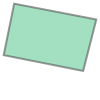

In [132]:
shape(df['features'][10]['geometry'])

In [ ]:
df_pd['geometry'] = df_pd['geoData'].apply(lambda x: shape(x))